<a href="https://colab.research.google.com/github/karencfisher/hotel-reviews/blob/main/notebooks/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.python.keras.utils.version_utils import TensorBoardVersionSelector
import pandas as pd
import numpy as np
import re
import datetime
import nltk
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_reviews = pd.read_csv('/content/drive/MyDrive/hotel_reviews/reviews.csv')
df_reviews.head()

,Cleanliness,Location,Overall,Rooms,Service,Sleep Quality,Value,Title,Content,Date,ReviewID
0,5,5,5,5,5,5,5,“Super stay.”,This the second time we have stayed and this t...,"April 20, 2012",UR128207934
1,5,5,4,4,5,5,4,“Permanent improvements in various aereas to b...,My experience as a rare but regular guest with...,"April 11, 2012",UR127662460
2,5,5,5,4,5,4,4,“span pacific orchard”,Great hotel in good location for night life & ...,"April 11, 2012",UR127648467
3,5,5,5,4,5,5,4,“Great value for money in heart of the shoppin...,The Pan Pac Orchard is in a great location rig...,"April 6, 2012",UR127365749
4,5,4,5,5,4,5,4,“Pan Pacific Orchard”,"Stayed for 3 nights. Hotel is clean, tasty foo...","April 2, 2012",UR127143142


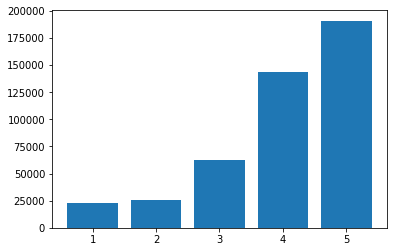

In [ ]:
plt.bar([1, 2, 3, 4, 5], df_reviews['Overall'].value_counts().sort_index());

### Baseline using Overall column as targets. 

Accuracy just randomly guessing the class for an example

In [ ]:
n_classes = df_reviews['Overall'].value_counts().values
n = df_reviews.shape[0]
baseline = np.sum((n_classes / n) ** 2)
print(f'Baseline accuracy: {baseline * 100: .2f}%')

Baseline accuracy:  31.42%


In [ ]:
# Drop date and reviewID columns
df_reviews.drop(columns=['Date', 'ReviewID'], inplace=True)

# Add column for average score (averaging ratings for each review)
cols = df_reviews.columns[:7]
df_reviews['average_score'] = df_reviews[cols].mean(axis=1)

# Drop individual category ratings
df_reviews.drop(columns=cols, inplace=True)

In [ ]:
df_reviews.head()

,Title,Content,average_score
0,“Super stay.”,This the second time we have stayed and this t...,5.000000
1,“Permanent improvements in various aereas to b...,My experience as a rare but regular guest with...,4.571429
2,“span pacific orchard”,Great hotel in good location for night life & ...,4.571429
3,“Great value for money in heart of the shoppin...,The Pan Pac Orchard is in a great location rig...,4.714286
4,“Pan Pacific Orchard”,"Stayed for 3 nights. Hotel is clean, tasty foo...",4.571429


### Distrubution of average scores

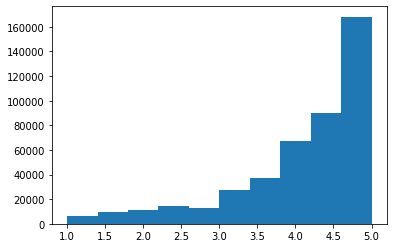

In [ ]:
plt.hist(df_reviews['average_score'], bins=10);

### Approximate baseline accuracy

Guessing randomly of 10 classes accross distribution of average_scores

In [ ]:
counts = np.histogram(df_reviews['average_score'], bins=10)[0]
n = df_reviews.shape[0]
baseline = np.sum((counts / n) ** 2)
print(f'Aporiximate baseline accuracy: {baseline * 100: .2f}%')

Aporiximate baseline accuracy:  22.13%


### Sample titles and descriptions by average score

In [ ]:
import textwrap

wrapper = textwrap.TextWrapper(width=140)
for i in range(1, 6):
  print(f'Average Score: {i}')
  cond = df_reviews['average_score'].astype(int) == i
  df_sample = df_reviews[cond].sample(10).sort_values(by='average_score')
  for row in range(len(df_sample)):
    print(df_sample.iloc[row]['Title'], '\n', f'Score = {df_sample.iloc[row]["average_score"]: .2f}')
    text = wrapper.wrap(df_sample.iloc[row]['Content'])
    for w in text:
      print(w)
    print('\n')
  print('*************\n')

Average Score: 1
“Avoid as much as possible. They are thieves.” 
 Score =  1.14
We got our stuff stolen from the hotel room (exp. laptop, iPads, smartphones, papers). Nobody cares. Their staff confirmed with us and
police that the door lock was broken initially but later they decided to "forget about it" and said that the door was working properly.
Their risk manager R.T. Germain ignored our phone calls and email for about a week (10-12 phone calls, about 6 answering machine messages
and NO REPLY)! I just suppose he supported the thieves. Their so-called 3rd party administrators (CCMSI Las Vegas) wasted about a month
trying to get any info from the hotel and finally decided that "Door was ok" and as far as we haven't used their tiny safe (no room for
laptop in their safe for sure) and door was ok hotel is right and we should get the [--] out of there. It seems they haven't contacted
neither Hotel Security officer who signed up our report neither police who saw the broken door lock. Sta

### Bucketize reviews into two sentiments, Good vs. Bad

Threshold = average score 3.5

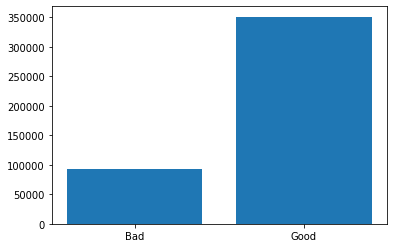

In [ ]:
df_reviews['sentiment'] = df_reviews['average_score'].apply(lambda x: 1 if x >= 3.5 else 0)
plt.bar(['Bad', 'Good'], df_reviews['sentiment'].value_counts().sort_index());

### Calculate a baseline accuracy

Randomly guessing 0 or 1 for each example

In [ ]:
num_classes = df_reviews['sentiment'].value_counts().values
n = df_reviews.shape[0]
baseline = np.sum((num_classes / n) ** 2)
print(f'Baseline accuracy: {baseline * 100: .2f}%')


Baseline accuracy:  66.89%


In [ ]:
nltk.download(['names', 'stopwords'])
stopwords = nltk.corpus.stopwords.words("english")

def cleanText(document):
  text = re.sub('[^a-zA-Z0-9 ]', '', document)
  tokens = text.lower().split()
  tokens = [w for w in tokens if w not in stopwords]
  return " ".join(tokens)

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_reviews['Title'] = df_reviews['Title'].apply(lambda x: x.replace('“','').replace('”',''))
df_reviews['Content'] = df_reviews['Title'] + ' ' + df_reviews['Content']
df_reviews.drop(columns=['Title'], inplace = True)
df_reviews['Content'] = df_reviews['Content'].apply(cleanText)
df_reviews.sample(10)


,Content,average_score,sentiment
156314,wonderful place stay second trip ocean resort ...,4.571429,1
411791,unusual place good way interesting hotel edge ...,3.571429,1
106882,great hotel secluded 22 parking stayed sister ...,4.000000,1
287149,westin napa verasa celebrated 20th wedding ann...,5.000000,1
412134,comfortable stay butler service professional a...,4.285714,1
128390,convenient location good value smallish 2store...,4.142857,1
31038,million dollar view ordinary accomodations sta...,4.142857,1
175281,perfect every way stayed 2 bedroom impeccable ...,5.000000,1
53586,would stay used hotel cruise 7 rooms booked ar...,4.285714,1
347279,donot stay hotel unless student worse hotel ev...,1.857143,0


### Make a CSV of a balanced sample

This way the baseline accuracy will be 50%

In [ ]:
df1 = df_reviews[df_reviews['sentiment'] == 1].sample(frac=0.05)
rows = df1.shape[0]
df0 = df_reviews[df_reviews['sentiment'] == 0].sample(rows)
df_sampled = pd.concat([df0, df1], axis = 0)

data_path = '/content/drive/MyDrive/hotel_reviews/reviews_sample.csv'
df_sampled.to_csv(data_path)
